In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


#Text Preprocessing Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer

#Deep Learning Libraries
import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPool1D, Dropout
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

In [3]:
train=pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip',sep='\t')
test=pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip',sep='\t')

In [4]:
train['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [5]:
def clean_sentences(df):
    reviews = []
    
    for sent in df['Phrase']:       
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", sent)
        
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
        
        #lemmatize each word to its lemma
        lemmatizer = WordNetLemmatizer()
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        
        reviews.append(lemma_words)
    
    return(reviews)

In [6]:
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)

print(len(train_sentences))
print(len(test_sentences))

156060
66292


In [7]:
print(train['Phrase'][0])
print(' '.join(train_sentences[0]))

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
a series of escapade demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amount to much of a story


In [8]:
from tensorflow.keras.utils import to_categorical

target = train.Sentiment.values
y_target = to_categorical(target)

# number of numerical values exist in y_target's column
num_classes = y_target.shape[1]

In [9]:
print(num_classes)

5


In [10]:
from sklearn.model_selection import train_test_split


In [11]:
X_train, X_val, y_train, y_val = train_test_split(train_sentences,
                                                  y_target,
                                                  test_size = 0.2,
                                                  stratify = y_target)

In [12]:
unique_words = set()
len_max = 0

for sent in (X_train):
    unique_words.update(sent)
    if(len_max < len(sent)):
        len_max = len(sent)

# length of the list of unique_words 
print('Number of vocabs: ', len(list(unique_words)))
print('Max length of text is: ', len_max)

Number of vocabs:  13737
Max length of text is:  48


In [13]:
vocab_size = len(list(unique_words))
embedding_dim = 300
max_length = len_max
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [14]:
tokenizer = Tokenizer(num_words = vocab_size,
                      # filters = '#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      oov_token = oov_tok,
                      # lower = True,
                      char_level = False)

tokenizer.fit_on_texts(list(X_train))

# Training
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,
                        maxlen = max_length,
                        padding = padding_type,
                        truncating = trunc_type)

# Validation
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val,
                      maxlen = max_length,
                      padding = padding_type,
                      truncating = trunc_type)

# Testing
X_test = tokenizer.texts_to_sequences(test_sentences)
X_test = pad_sequences(X_test,
                       maxlen = max_length,
                       padding = padding_type,
                       truncating = trunc_type)

In [15]:
print("X_training shape   : ",X_train.shape)
print("X_validation shape : ",X_val.shape)
print("X_testing shape    : ",X_test.shape)

X_training shape   :  (124848, 48)
X_validation shape :  (31212, 48)
X_testing shape    :  (66292, 48)


**2) DEEP LEARNING APPROACH**

In [16]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,MaxPooling1D,Flatten

In [17]:
early_stopping = EarlyStopping(min_delta = 0.001,
                               mode = 'max',
                               monitor = 'val_acc',
                               patience = 2)
callback = [early_stopping]

In [18]:
model = Sequential()
model.add(Embedding(vocab_size,300,input_length = max_length))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(256, dropout = 0.8, recurrent_dropout=0.8, return_sequences=True)))
model.add(Bidirectional(LSTM(128,dropout = 0.5,recurrent_dropout=0.5,return_sequences=True)))
model.add(Bidirectional(GRU(128,return_sequences=False)))
model.add(Dropout(0.4))
model.add(Dense(5,activation='softmax'))

2022-05-07 08:39:04.584729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 08:39:04.691173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 08:39:04.692345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 08:39:04.693957: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 300)           4121100   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 48, 300)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 48, 512)           1140736   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 48, 256)           656384    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1

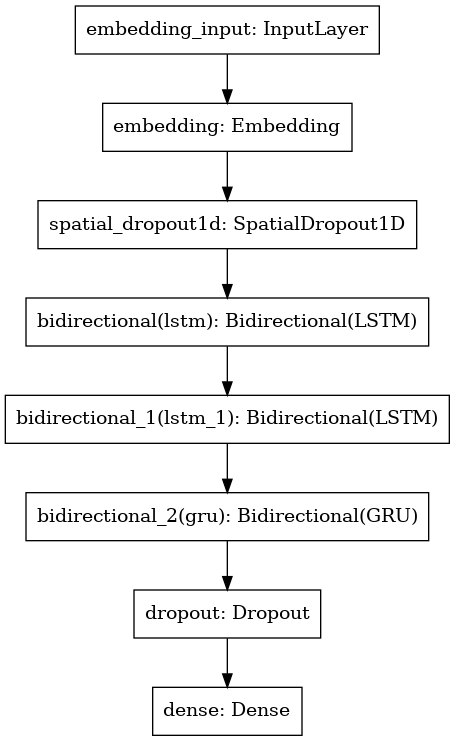

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
history=model.fit(X_train, y_train,batch_size=512, epochs=10,verbose=1,callbacks=callback,validation_split=0.1)

2022-05-07 08:39:10.553883: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-05-07 08:39:27.269585: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


220/220 [==============================] - 282s 1s/step - loss: 1.1485 - accuracy: 0.5444 - val_loss: 0.9451 - val_accuracy: 0.6156
Epoch 2/10
220/220 [==============================] - 266s 1s/step - loss: 0.9143 - accuracy: 0.6310 - val_loss: 0.8593 - val_accuracy: 0.6486
Epoch 3/10
220/220 [==============================] - 265s 1s/step - loss: 0.8391 - accuracy: 0.6585 - val_loss: 0.8277 - val_accuracy: 0.6608
Epoch 4/10
220/220 [==============================] - 266s 1s/step - loss: 0.8022 - accuracy: 0.6735 - val_loss: 0.8264 - val_accuracy: 0.6599
Epoch 5/10
220/220 [==============================] - 265s 1s/step - loss: 0.7742 - accuracy: 0.6853 - val_loss: 0.8240 - val_accuracy: 0.6642
Epoch 6/10
220/220 [==============================] - 269s 1s/step - loss: 0.7501 - accuracy: 0.6938 - val_loss: 0.8052 - val_accuracy: 0.6714
Epoch 7/10
220/220 [==============================] - 271s 1s/step - loss: 0.7295 - accuracy: 0.7005 - val_loss: 0.8052 - val_accuracy: 0.6678
Epoch 8/10

In [23]:
model.save('Model.h5')

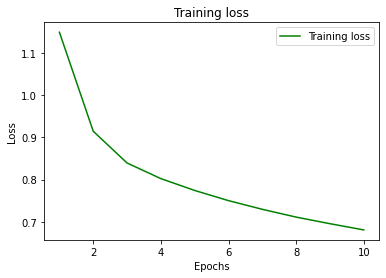

In [24]:
loss_train = history.history['loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


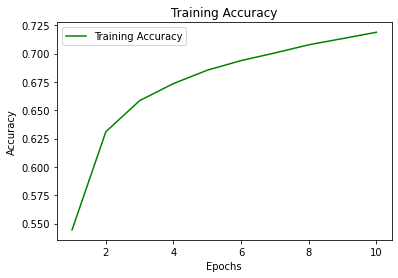

In [25]:
accuracy_train = history.history['accuracy']
epochs = range(1,11)
plt.plot(epochs, accuracy_train, 'g', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

In [27]:
classes_x

array([2, 2, 2, ..., 2, 2, 1])

In [28]:
np.unique(classes_x)

array([0, 1, 2, 3, 4])

In [29]:
submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
submission_file['Sentiment']=classes_x
submission_file.to_csv('Submission_DeepLearning.csv',index=False)